# Análise Exploratória de Dados em Python &ndash; Parte 2

Agora que já identificamos quais são as proteínas melhores candidatas a indicar algum efeito do tratamento, vamos tentar aprofundar um pouco mais a análise, identificar possíveis correlações e testar a hipótese de que esteja havendo algum efeito no tratamento. (Não necessariamente o efeito desejado de resgatar a capacidade cognitiva dos ratos, isso não poderia ser testado com um teste clínico químico, apenas com testes de habilidade cognitiva.)

Se você não fez isso ainda, retorne ao notebook da parte 1 desta tarefa e salve o conjunto de nomes de colunas que foram selecionadas como candidatas. Digamos, em um arquivo chamado `candidate-columns.csv`. Em seguida, **neste** notebook:

1. Carrege o arquivo `candidate-columns.csv`;
2. Carrege o arquivo `Data_Cortex_Nuclear.xls`;
3. Gere um dataframe apenas com o `MouseID` e as columas candidatas.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_excel('Data_Cortex_Nuclear.xls')

with open('candidate-columns.csv', 'r') as f:
    candidate_columns = f.read().splitlines()

proteins = df.loc[:, df.dtypes == float].keys().tolist()
for i in proteins:
    df.pop(i) if i not in candidate_columns else None

objects = df.loc[:, df.dtypes == object].keys().tolist()
# for i in objects:
#     df.pop(i) if i != 'MouseID' else None

# fill empty values
df = df.fillna(df.mean())

df.head(1)

,MouseID,DYRK1A_N,ITSN1_N,NR2A_N,pCAMKII_N,pELK_N,pERK_N,PKCA_N,pNR2A_N,pPKCAB_N,...,BCL2_N,pCFOS_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,5.990152,2.373744,1.750936,0.687906,0.402698,0.605673,2.308745,...,0.134762,0.108336,0.114783,0.13179,0.128186,1.675652,Control,Memantine,C/S,c-CS-m


### Estrutura de identificação

Além de procurar desvios, é importante identificar a estrutura latente nos dados. Existem várias técnicas para realizar isso. A mais simples seria a inspeção visual da distribuição espacial dos pontos de dados. Infelizmente, frequentemente temos muitas dimensões, o que impede o uso de plotagem simples para vizualizar os dados. Neste exercício, provavelmente o conjunto de variáveis candidatas ainda está com uma dezena ou mais de proteínas. Portanto, precisamos de outras técnicas para ter uma idéia da distribuição e estrutura dos dados.

Clusterização é uma boa maneira de expor a estrutura nos dados. Algoritmos de clustering hierárquicos são bons porque não é necessário especificar uma contagem de clusteres. Algoritmos de clustering hierárquicos também dão às suas variáveis uma ordem parcial, da qual você pode tirar proveito. Uma boa forma de agrupamento é uma técnica chamada _Hierarchical DBSCAN_ ou _HDBSCAN_. Esta técnica usa o tamanho mínimo do cluster como o único parâmetro e produz clustering discreto e hierárquico.

O HDBSCAN (disponível no pacote [hdbscan](https://hdbscan.readthedocs.io/en/latest/api.html)) é um algoritmo de clustering. Ele estende o DBSCAN convertendo-o em um algoritmo de clustering hierárquico e, em seguida, usando uma técnica para extrair um cluster simples baseado na estabilidade de clusters. O DBSCAN (Density-based spatial clustering of applications with noise) é um algoritmo de clusterização de dados. É um algoritmo de clusterização baseado em densidade: dado um conjunto de pontos em algum espaço, agrupa pontos que estão intimamente agrupados (pontos com muitos vizinhos próximos), marcando como outliers (pontos que ficam sozinhos em regiões de baixa densidade vizinhos estão muito longe). O DBSCAN é um dos algoritmos de clusterização mais comuns e também um dos mais citados na literatura científica.

**Atenção:** Infelizmente, a biblioteca _hdbscan_ não vem instalada por padrão no Anaconda. Para instalá-la, execute o comando abaixo:
```
conda install -c conda-forge hdbscan
```
Veja [esta página](https://pypi.org/project/hdbscan/) para mais detalhes.

Há um tutorial de como o HDBSCAN funciona [aqui](https://hdbscan.readthedocs.io/en/latest/api.html). (Não é necessário, por enquanto, entrar na parte de _Build the minimum spanning tree_ do tutorial.)

Identificar se existem clusteres, e quanto são eles, e seus tamanhos, nos ajuda a ter uma melhor “visão” da estrutura dos dados. Porém, simplesmente imprimir os clusteres pode não ser muito útil. Talvez seja melhor apenas tentar obter a informação de quantos clusteres de cada tamanho existem.

Para exemplificar o uso do HDBSCAN vamos utilziar um conjunto de dados sobre ausências no trabalho, disponível [aqui](https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work). Agora considere o código abaixo.


In [2]:
dfaw = pd.read_csv('Absenteeism_at_work.csv', sep=';')
dfaw.head(1)

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4


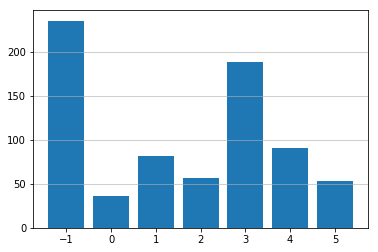

In [3]:
import hdbscan

# Cria uma instância do clusterizador com tamanho mínimo de cluster igual a 25.
clust = hdbscan.HDBSCAN(min_cluster_size=25)

# Aplica o clusterizador nos dados para identificação dos clusteres.
fit_dfaw = clust.fit(dfaw)

# Cria uma série de dados contendo o número do cluster e o índice do ponto de 
# dados no dataset original que pertence àquele cluster. Pontos considerados ruído, 
# i.e., não associados a nenhum cluster receberão o label `-1`.
clusters_base_info = pd.Series(fit_dfaw.labels_, index=dfaw.index)

num_bins = len(clusters_base_info.unique())

# Mostra, através de um histograma, quais clusteres foram identificados, e quantos 
# pontos de dados foram atribuídos a cada cluster.
plt.hist(clusters_base_info, num_bins, rwidth=0.8, range=(-1.5,(num_bins-2)+0.5))
plt.grid(axis='y', alpha=0.75)
plt.show()

O gráfico acima permite ver que foram identificados 6 clusteres, rotulados de 0 a 6, e que pouco menos de 250 instâncias foram rotuladas como ruído, ou seja, não pertencem a nenhum cluster. Também é possível ver que o maior cluster é o cluster 3, que compreende pouco menos de 200 instâncias.

Abora experimente com o conjunto de dados com o qual estamos trabalhando, i.e., com o conjunto de dados contendo os dados das proteínas candidatas. Experimente com diferentes valores de tamanho mínimo de cluster e veja se você consegue identifcar a estrutura do nosso conjunto de dados.

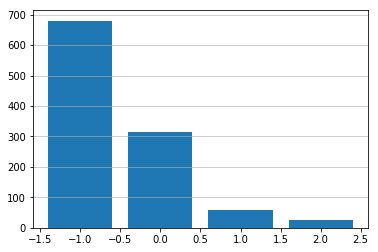

In [4]:
clust = hdbscan.HDBSCAN(min_cluster_size=15)
fit_df = clust.fit(df.loc[:, df.dtypes == float])
clusters_base_info = pd.Series(fit_df.labels_, index=df.index)
num_bins = len(clusters_base_info.unique())
plt.hist(clusters_base_info, num_bins, rwidth=0.8, range=(-1.5,(num_bins-2)+0.5))
plt.grid(axis='y', alpha=0.75)
plt.show()

Uma vez que tenhamos identificado uma definição de clusteres que pareça adequada, podemos proceder uma pequena inspeção nos elementos de cada cluster. Por exemplo, considere o código abaixo.

```
mask = interesting_sample_clusters == 0
groups = df[mask].join(interesting_sample_clusters).groupby(["Genotype", "Treatment", "Behavior"])
groups.count()[["cluster"]]
```

Esse código cria uma máscara com as instâncias que pertencem ao cluster 0 (supondo que os dados com os labels dos clusteres foram gerado como o exemplo do histograma acima, e gravado na série `interesting_sample_clusters`). Em seguida usa esta máscara para fazer o `groupby` apenas destas instâncias, agrupando por `Genotype`, por `Treatment`, e por `Behavior`. Finalmente, o código gera uma tabela com as quantidades de instâncias em cada combinação destes três atributos.

Execute a operação indicada, e veja se é possível inferir algum tipo de padrão nos clusteres que foram identificados.

In [5]:
from collections import defaultdict

clusters = sorted(clusters_base_info.unique().tolist())
dict_clusters = defaultdict(dict)

for cluster in clusters:
    mask = clusters_base_info == cluster
    groups = df[mask].join(clusters_base_info.to_frame())\
                     .groupby(["Genotype", "Treatment", "Behavior"]) # <-- precisei adicionar .to_frame()
    # print('\n:: Cluster', cluster, '\n', groups.count()[[0]][0])
    for i in groups.count()[[0]][0].items():
        key = str(i[0])[2:-2].replace("', '", ' ')
        dict_clusters[cluster][key] = i[1]

df_clusters = pd.DataFrame.from_dict(dict_clusters)
df_clusters
    
# Genotype: control (c) or trisomy (t)
# Treatment type: memantine (m) or saline (s)
# Behavior: context-shock (CS; stimulated to learn) or shock-context (SC; not stimulated to learn)
# Class: c-CS-s, c-CS-m, c-SC-s, c-SC-m, t-CS-s, t-CS-m, t-SC-s, t-SC-m 

,-1,0,1,2
Control Memantine C/S,138,9,2.0,1.0
Control Memantine S/C,31,119,NaN,NaN
Control Saline C/S,115,1,19.0,NaN
Control Saline S/C,61,74,NaN,NaN
Ts65Dn Memantine C/S,94,14,26.0,1.0
Ts65Dn Memantine S/C,61,74,NaN,NaN
Ts65Dn Saline C/S,87,6,12.0,NaN
Ts65Dn Saline S/C,93,17,NaN,25.0


Descreva que tipo de intuição você pode tirar das informações mostradas pelos quadros que foram gerados acima. Como você acha que esta intuição pode ajudar a determinar se o tratamento está tendo algum efeito ou não?

**Resposta:** No cluster 0 identificado, notam-se níveis maiores em ratos com trissomia que foram administrados com memantina, quando comparados com ratos injetados com solução salina, tanto no grupo de aprendizado estimulado quanto no grupo não estimulado.

A esta altura, devemos ter chegado a um conjunto relativamente restrito de variáveis em nosso conjunto de dados. O próximo passo é calcular a **matriz de covariância** e desenhá-la, para ver se há correlações entre as variáveis que sobraram.

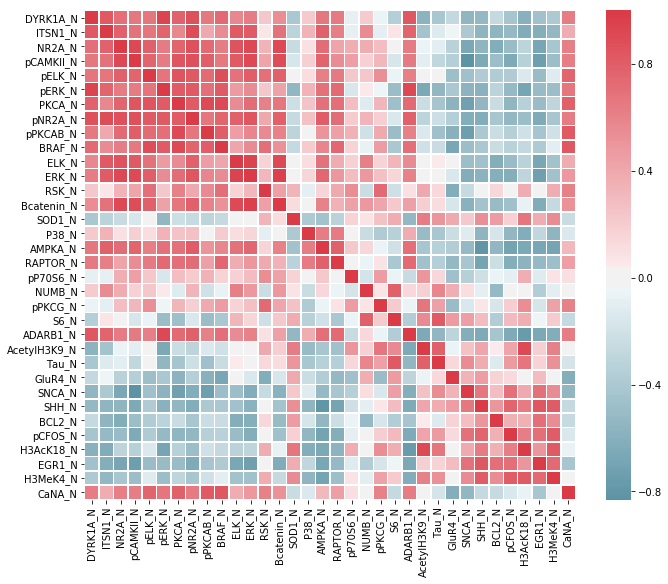

In [6]:
import seaborn as sns
df_num = df[mask] # <-- seria isso mesmo..?
df_corr = df_num.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, cmap=cmap, center=0, linewidths=0.5)

Com a informação da covariância entre os atributos, como isso influencia no teste de hipóteses?

**Resposta:**

As proteínas identificadas com alta covariância entre si indicam prováveis candidatas a efeitos experimentais.

Qual será a sua hipótese nula, $H_0$? E qual será a hipótese alternativa? Que método você pretende usar para testar estas hipóteses?

**Resposta:**

A hipótese nula (H0) é de que os tratamentos são equivalentes e diferenças entre os grupos são devidas ao acaso. A hipótese alternativa (Ha) é de que os resultados para os grupos são mais diferentes do que aleatoriamente seria possível. Para testá-las, propõe-se um teste de permutação.

Agora, implemente o teste da hipótese e escreva suas conclusões finais.

In [7]:
def permutation_test_mean(pooled, n1, n2):
    np.random.shuffle(pooled)
    x = pooled[:n1]
    y = pooled[-n2:]
    return x.mean() - y.mean()

for protein in df.loc[:, df.dtypes == float].keys().tolist():
    df_a = df[clusters_base_info == 0]
    df_b = df[clusters_base_info == 1]
    a = df_a[protein].values
    b = df_b[protein].values
    delta = a.mean() - b.mean()
    # print(delta)
    num_samples = 10000
    pooled = np.hstack([a,b])
    estimates = np.array(list(map(lambda x: permutation_test_mean(pooled, a.size, b.size), range(num_samples))))
    less_extremes = np.where(estimates <= delta)[0]
    p = 1.0 - float(len(less_extremes))/float(num_samples)
    # print(p)
    if p < 0.05:
        print(protein, '   \t null hypothesis rejected (p < alpha 0.05)')
        # plotar um histograma das estimativas
        # fig, ax = plt.subplots(figsize=(15,9))
        # n, bins, patches = ax.hist(x=estimates, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
        # ax.axvline(delta, color='k', linestyle='dashed', linewidth=2)
        # ax.grid(axis='y', alpha=0.75)
        # ax.set_xlabel('Distribuição das Diferenças das Médias')
        # ax.set_ylabel('Frequência')
        # ax.set_title('Teste de Permutação com a proteína', p)

pCAMKII_N    	 null hypothesis rejected (p < alpha 0.05)
pNR2A_N    	 null hypothesis rejected (p < alpha 0.05)
ELK_N    	 null hypothesis rejected (p < alpha 0.05)
RSK_N    	 null hypothesis rejected (p < alpha 0.05)
SOD1_N    	 null hypothesis rejected (p < alpha 0.05)
P38_N    	 null hypothesis rejected (p < alpha 0.05)
AMPKA_N    	 null hypothesis rejected (p < alpha 0.05)
RAPTOR_N    	 null hypothesis rejected (p < alpha 0.05)
GluR4_N    	 null hypothesis rejected (p < alpha 0.05)
SNCA_N    	 null hypothesis rejected (p < alpha 0.05)
SHH_N    	 null hypothesis rejected (p < alpha 0.05)
BCL2_N    	 null hypothesis rejected (p < alpha 0.05)
pCFOS_N    	 null hypothesis rejected (p < alpha 0.05)
H3AcK18_N    	 null hypothesis rejected (p < alpha 0.05)
EGR1_N    	 null hypothesis rejected (p < alpha 0.05)
H3MeK4_N    	 null hypothesis rejected (p < alpha 0.05)


**R:** Considerando-se um valor alpha de 0.05, um total de 16 proteínas acima apresentaram um valor *p < 0.05* (descartando-se a hipótese nula).